In [123]:
# load the saved parameters and do visualization for W, a and C_alpha.
import numpy as np
import matplotlib.pyplot as plt
import pickle


path = '/data3/wangshaobo/ICL/RPE/results_paper/NGram/C_W_a_parent3_n10000_L100_S3_H5_1.0_100.0_1.0_optsgd_w+2.0_w-0.1_D3_c_alpha_init0.01_a_init0.01_alpha0.1_n-epochs[500, 500, 1].npz'
data = np.load(path)

# extract info from path, about L, S, H
path = path.split('/')[-1]
path = path.split('_')
L = int(path[5][1:])
S = int(path[6][1:])
H = int(path[7][1:])
D = path[14][1:]
print('L, S, H, D', L, S, H, D)



L, S, H, D 100 3 5 3


In [124]:
# check the dict of data saved with npz
print(data.files)
alphas = data['alphas']

['C_list', 'train_loss_list_1', 'val_loss_list_1', 'alphas', 'W_before', 'train_loss_list_2', 'val_loss_list_2', 'W_after', 'a_list', 'train_loss_list_3', 'val_loss_list_3']


(501, 26)


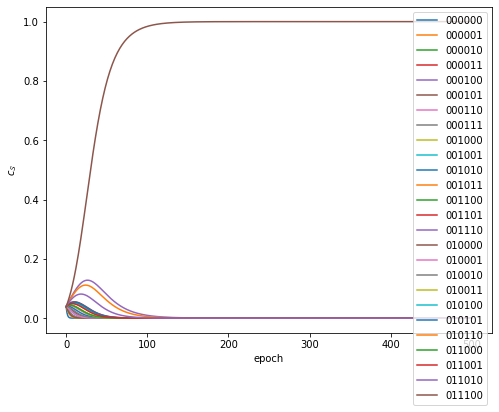

In [125]:
# plot C_list curve, C_list is a list of multiple C_alpha, draw the curve of each alpha.
# each alpha is corrensding to a binary coding of H+1 positions, change alpha to binary, then to a list of 0 and 1.
C_list = data['C_list']
# plot the ratio of each C_alpha **2 over the some of all C_alpha**2
C_list = C_list**2
C_list = C_list / np.sum(C_list, axis = 1)[:,np.newaxis]
print(C_list.shape)

plt.figure(figsize=(8,6))
for i in range(len(alphas)):
    plt.plot(C_list[:,i], label = alphas[i])
    plt.legend()
plt.xlabel('epoch')
plt.ylabel(r'$c_\mathcal{S}$')
plt.show()

Text(0.5, 1.0, 'W_after')

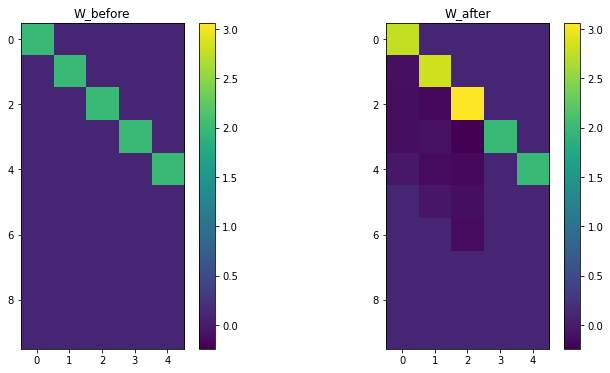

In [127]:
# draw W_before and W_after heatmap
W_before = data['W_before'][0][:10,:10]
W_after = data['W_after'][0][:10,:10]
# Get the min and max values for normalization
vmin = min(W_before.min(), W_after.min())
vmax = max(W_before.max(), W_after.max())

# Create the figure and subplots
plt.figure(figsize=(12, 6))

# Plot W_before
plt.subplot(1, 2, 1)
plt.imshow(W_before, aspect='equal', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('W_before')

# Plot W_after
plt.subplot(1, 2, 2)
plt.imshow(W_after, aspect='equal', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('W_after')



In [110]:
'''
for h in range(H):
    W_h = torch.full((T+1, T+1), float('-inf'), device=X.device) # [T+1, T+1]
    for j in range(H):
        torch.diagonal(W_h, -(j+h+1)).fill_(self.W[:, h][j+h])  # Set the (j)-th negative diagonal
'''
import torch

def create_matrix_RPE(W):
    W_list = []
    for h in range(H):
        W_h = torch.full((L+1, L+1), float('-inf')) # [T+1, T+1]
        for j in range(H):
            torch.diagonal(W_h, -(j+h+1)).fill_(W[:, h][j+h])  # Set the (j)-th negative diagonal
        W_list.append(W_h)
    return W_list

In [111]:
# RPE matrix for W_before and W_after
W_after_RPE = create_matrix_RPE(W_after)
W_before_RPE = create_matrix_RPE(W_before)

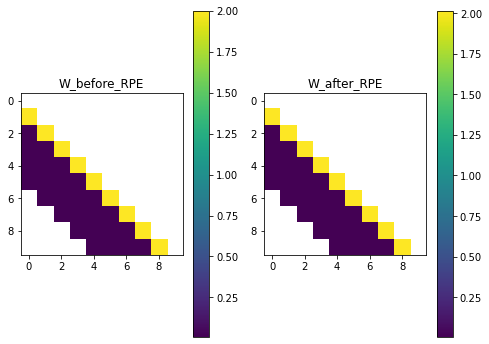

In [118]:
# plot W_before RPE matrix, W_after RPE matrix

for h in range(1):
    # set equal colorbar for w_h_after and w_h_before heatmap
    plt.figure(figsize=(8,6))
    w_h_before = W_before_RPE[h][:10,:10]
    w_h_after = W_after_RPE[h][:10,:10]
    # colormap
    plt.subplot(1,2,1)
    plt.imshow(w_h_before, aspect='equal')
    plt.colorbar()
    plt.title('W_before_RPE')
    plt.subplot(1,2,2)
    plt.imshow(w_h_after, aspect='equal')
    plt.colorbar()
    plt.title('W_after_RPE')
    plt.show()